# Convolutional neural network for the human activities recognition
* using preprocessed data in shape (samples, window-shape, components) to train and test the model
* analyzes motor activities based on signals from sensors
* its six activities: walking, standing, sitting, laying, walking up and downstairs

In [1]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import seaborn as sns
import tensorflow as tf
from tensorflow import keras, lite
from keras.models import Sequential
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers import Dense, Dropout, Flatten
%matplotlib inline

# Loading and reshaping data

In [2]:
# Loading from the .txt files
X_train = np.loadtxt('GeneralData/X_train.txt')
X_test = np.loadtxt('GeneralData/X_test.txt')
y_train = np.loadtxt('GeneralData/y_train.txt')
y_test = np.loadtxt('GeneralData/y_test.txt')

In [5]:
# Shape of X and y data before reshaping
X_train.shape, y_train.shape

((7279, 1152), (7279,))

In [6]:
# Reshaping y data
y_test = np.reshape(y_test,(y_test.shape[0],1))
y_train = np.reshape(y_train,(y_train.shape[0],1))
# Changing the type (int) and decrease the indexes by one - to fit it with binary class matrix (output)
y_test = y_test.astype(int) - 1
y_train = y_train.astype(int) - 1

In [7]:
# Converts an y vectors to binary class matrix
y_test_cat = keras.utils.to_categorical(y_test)
y_train_cat = keras.utils.to_categorical(y_train)

In [8]:
# Visualisating output
y_test_cat[:5]

array([[0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0., 0.]], dtype=float32)

In [9]:
# Reshaping X data into (samples, windows-shape, compontents) 
# values from the SingalPreprocessing
samples = 10399
window_shape = 128
components = 9

X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1] // components, components))
X_train = np.reshape (X_train, (X_train.shape[0], X_train.shape[1] // components, components))

In [10]:
# X after reshaping
X_train.shape, X_test.shape

((7279, 128, 9), (3120, 128, 9))

* Data is prepared to use into training process

# Modeling CNN
* fitting
* testing and evaluating

In [78]:
#Creating model
def createModel(nr_filter, nr_kernel):
    model = Sequential()
    # Adding layers
    # first convolution
    model.add(Conv1D(filters=nr_filter, kernel_size=nr_kernel, input_shape=X_train.shape[1:], activation='relu'))
    # second convolution, the number of filteres divided by 2
    model.add(Conv1D(nr_filter/2, nr_kernel, activation='relu'))
    # max pooling size 2
    model.add(MaxPooling1D(2))
    # only 50% of data goes on
    model.add(Dropout(0.5))
    # flattering the matrix
    model.add(Flatten())
    # deeply connected layer with 125 units
    model.add(Dense(units=125, activation='relu'))
    # deeply connected layer with 6 units = 6 activities
    model.add(Dense(units=6, activation='softmax'))
    # Model Visualisation
    model.summary()
    # Model compilation
    model.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics=['accuracy'])
    # Return model
    return model

* the optimizer is adam
* using categorical cross entropy because labels are one-hot represenation and more then one class
* two dropout layers to avoid overfitting
* activation function is ReLU

In [53]:
# Getting model with properties
def getModel(epochs, batch, nr_filter, nr_kernel):
    # Model creating
    model = createModel(nr_filter,nr_kernel)
    # Model fitting
    model.fit(x=X_train, y=y_train_cat, epochs=epochs, batch_size=batch, validation_data=(X_test,y_test_cat))
    # Getting model properties
    model_feat = pd.DataFrame(model.history.history)
    # Getting loss values
    model_loss = model_feat[['loss','val_loss']]
    # Return model, model loss and model properties
    return model, model_loss, model_feat

In [54]:
from sklearn.metrics import classification_report, confusion_matrix

# Model properties
def propModel(model, loss):
    # predictions of model using testing dataset
    y_pred = model.predict(X_test)
    # changing form of output data
    y_pred = np.argmax(y_pred, axis=1)
    y_real = np.argmax(y_test_cat, axis=1)
    # showing properties
    print('--------------------------------Classification report-')
    print(' ')
    print(classification_report(y_real,y_pred))
    print(' ')
    print('-------------------------------------Confusion matrix-')
    print(' ')
    print(confusion_matrix(y_real,y_pred))
    print(' ')
    print('-------------------------------------Loss Values plot-')
    loss.plot()

In [55]:
# Fitting components

epochs_nr = 11 # number of epochs during the training, it is a right value when i checked a model
batch_val = 29 # batch size 7279/29 = 251

In [56]:
# Model: filter size = 128, kernel size = 5

model1, loss1, prop1 = getModel(epochs_nr,batch_val, 128, 5)

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_28 (Conv1D)          (None, 124, 128)          5888      
                                                                 
 conv1d_29 (Conv1D)          (None, 120, 64)           41024     
                                                                 
 max_pooling1d_14 (MaxPoolin  (None, 60, 64)           0         
 g1D)                                                            
                                                                 
 dropout_22 (Dropout)        (None, 60, 64)            0         
                                                                 
 flatten_14 (Flatten)        (None, 3840)              0         
                                                                 
 dense_28 (Dense)            (None, 125)               480125    
                                                     

98/98 [==============================] - 1s 11ms/step
--------------------------------Classification report-
 
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       532
           1       0.97      1.00      0.98       462
           2       1.00      0.94      0.97       421
           3       0.87      0.84      0.86       530
           4       0.86      0.88      0.87       586
           5       1.00      1.00      1.00       589

    accuracy                           0.94      3120
   macro avg       0.94      0.94      0.94      3120
weighted avg       0.94      0.94      0.94      3120

 
-------------------------------------Confusion matrix-
 
[[530   0   0   0   2   0]
 [  2 460   0   0   0   0]
 [ 10  16 395   0   0   0]
 [  0   0   0 446  84   0]
 [  1   0   0  67 518   0]
 [  0   0   0   0   0 589]]
 
-------------------------------------Loss Values plot-


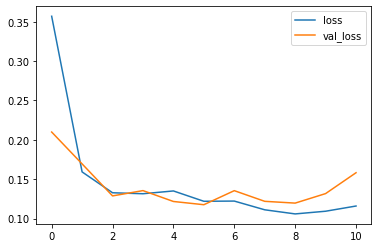

In [57]:
# Properties of the model visualisation
propModel(model1,loss1)

In [58]:
# Second model: filter size = 128, kernel size = 3

model2, loss2, prop2 = getModel(epochs_nr,batch_val, 128, 3)

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_30 (Conv1D)          (None, 126, 128)          3584      
                                                                 
 conv1d_31 (Conv1D)          (None, 124, 64)           24640     
                                                                 
 max_pooling1d_15 (MaxPoolin  (None, 62, 64)           0         
 g1D)                                                            
                                                                 
 dropout_23 (Dropout)        (None, 62, 64)            0         
                                                                 
 flatten_15 (Flatten)        (None, 3968)              0         
                                                                 
 dense_30 (Dense)            (None, 125)               496125    
                                                     

98/98 [==============================] - 1s 5ms/step
--------------------------------Classification report-
 
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       532
           1       0.98      1.00      0.99       462
           2       0.99      1.00      0.99       421
           3       0.86      0.87      0.86       530
           4       0.88      0.86      0.87       586
           5       1.00      1.00      1.00       589

    accuracy                           0.95      3120
   macro avg       0.95      0.95      0.95      3120
weighted avg       0.95      0.95      0.95      3120

 
-------------------------------------Confusion matrix-
 
[[523   5   4   0   0   0]
 [  1 461   0   0   0   0]
 [  0   2 419   0   0   0]
 [  1   1   0 462  66   0]
 [  2   1   0  77 506   0]
 [  0   0   0   0   0 589]]
 
-------------------------------------Loss Values plot-


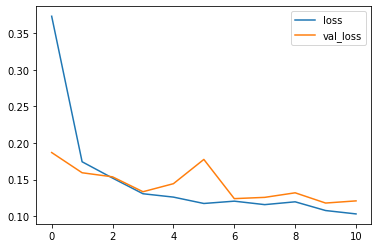

In [59]:
# Properties of the model visualisation
propModel(model2,loss2)

In [60]:
# Next model: filter size = 128, kernel size = 7

model3, loss3, prop3 = getModel(epochs_nr,batch_val, 128, 7)

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_32 (Conv1D)          (None, 122, 128)          8192      
                                                                 
 conv1d_33 (Conv1D)          (None, 116, 64)           57408     
                                                                 
 max_pooling1d_16 (MaxPoolin  (None, 58, 64)           0         
 g1D)                                                            
                                                                 
 dropout_24 (Dropout)        (None, 58, 64)            0         
                                                                 
 flatten_16 (Flatten)        (None, 3712)              0         
                                                                 
 dense_32 (Dense)            (None, 125)               464125    
                                                     

98/98 [==============================] - 1s 11ms/step
--------------------------------Classification report-
 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       532
           1       1.00      1.00      1.00       462
           2       1.00      1.00      1.00       421
           3       0.82      0.92      0.87       530
           4       0.92      0.81      0.86       586
           5       1.00      1.00      1.00       589

    accuracy                           0.95      3120
   macro avg       0.95      0.95      0.95      3120
weighted avg       0.95      0.95      0.95      3120

 
-------------------------------------Confusion matrix-
 
[[532   0   0   0   0   0]
 [  1 461   0   0   0   0]
 [  0   1 420   0   0   0]
 [  0   0   0 486  44   0]
 [  1   1   0 107 477   0]
 [  0   0   0   0   0 589]]
 
-------------------------------------Loss Values plot-


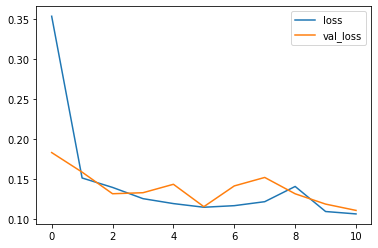

In [61]:
# Properties of the model visualisation
propModel(model3,loss3)

In [79]:
# Next model: filter size = 64, kernel size = 11

model4, loss4, prop4 = getModel(epochs_nr,batch_val, 128, 11)

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_50 (Conv1D)          (None, 118, 128)          12800     
                                                                 
 conv1d_51 (Conv1D)          (None, 108, 64)           90176     
                                                                 
 max_pooling1d_25 (MaxPoolin  (None, 54, 64)           0         
 g1D)                                                            
                                                                 
 dropout_33 (Dropout)        (None, 54, 64)            0         
                                                                 
 flatten_25 (Flatten)        (None, 3456)              0         
                                                                 
 dense_50 (Dense)            (None, 125)               432125    
                                                     

98/98 [==============================] - 1s 13ms/step
--------------------------------Classification report-
 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       532
           1       1.00      1.00      1.00       462
           2       1.00      1.00      1.00       421
           3       0.84      0.87      0.85       530
           4       0.88      0.84      0.86       586
           5       1.00      1.00      1.00       589

    accuracy                           0.95      3120
   macro avg       0.95      0.95      0.95      3120
weighted avg       0.95      0.95      0.95      3120

 
-------------------------------------Confusion matrix-
 
[[532   0   0   0   0   0]
 [  0 462   0   0   0   0]
 [  0   0 421   0   0   0]
 [  0   0   0 462  68   0]
 [  0   1   0  91 494   0]
 [  0   0   0   0   0 589]]
 
-------------------------------------Loss Values plot-


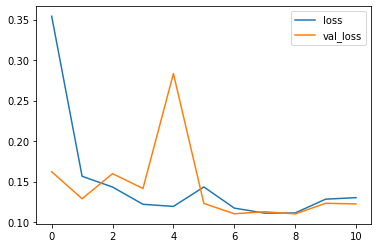

In [80]:
# Properties of the model visualisation
propModel(model4,loss4)

* the best properties for the kernel-size: 7, for lower is overfitted, larger is with higher loss value

In [74]:
# Next model: filter size = 64, kernel size = 7

model5, loss5, prop5 = getModel(epochs_nr,batch_val, 64, 7)

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_46 (Conv1D)          (None, 122, 64)           4096      
                                                                 
 conv1d_47 (Conv1D)          (None, 116, 32)           14368     
                                                                 
 max_pooling1d_23 (MaxPoolin  (None, 58, 32)           0         
 g1D)                                                            
                                                                 
 dropout_31 (Dropout)        (None, 58, 32)            0         
                                                                 
 flatten_23 (Flatten)        (None, 1856)              0         
                                                                 
 dense_46 (Dense)            (None, 125)               232125    
                                                     

98/98 [==============================] - 1s 7ms/step
--------------------------------Classification report-
 
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       532
           1       0.99      1.00      0.99       462
           2       1.00      1.00      1.00       421
           3       0.87      0.84      0.86       530
           4       0.86      0.89      0.87       586
           5       1.00      1.00      1.00       589

    accuracy                           0.95      3120
   macro avg       0.95      0.95      0.95      3120
weighted avg       0.95      0.95      0.95      3120

 
-------------------------------------Confusion matrix-
 
[[522   6   0   0   4   0]
 [  0 460   0   2   0   0]
 [  0   0 421   0   0   0]
 [  0   0   0 446  84   0]
 [  0   0   0  63 523   0]
 [  0   0   0   0   0 589]]
 
-------------------------------------Loss Values plot-


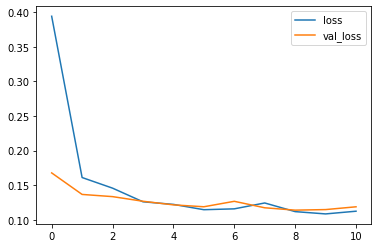

In [75]:
# Properties of the model visualisation
propModel(model5,loss5)

In [72]:
# Next model: filter size = 32, kernel size = 7

model6, loss6, prop6 = getModel(epochs_nr,batch_val, 32, 7)

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_44 (Conv1D)          (None, 122, 32)           2048      
                                                                 
 conv1d_45 (Conv1D)          (None, 116, 16)           3600      
                                                                 
 max_pooling1d_22 (MaxPoolin  (None, 58, 16)           0         
 g1D)                                                            
                                                                 
 dropout_30 (Dropout)        (None, 58, 16)            0         
                                                                 
 flatten_22 (Flatten)        (None, 928)               0         
                                                                 
 dense_44 (Dense)            (None, 125)               116125    
                                                     

98/98 [==============================] - 0s 3ms/step
--------------------------------Classification report-
 
              precision    recall  f1-score   support

           0       0.99      0.98      0.98       532
           1       0.96      1.00      0.98       462
           2       0.99      0.99      0.99       421
           3       0.82      0.91      0.86       530
           4       0.91      0.81      0.86       586
           5       1.00      1.00      1.00       589

    accuracy                           0.94      3120
   macro avg       0.95      0.95      0.95      3120
weighted avg       0.94      0.94      0.94      3120

 
-------------------------------------Confusion matrix-
 
[[520   9   3   0   0   0]
 [  0 462   0   0   0   0]
 [  0   4 417   0   0   0]
 [  2   1   0 481  46   0]
 [  2   4   0 106 474   0]
 [  0   0   0   0   0 589]]
 
-------------------------------------Loss Values plot-


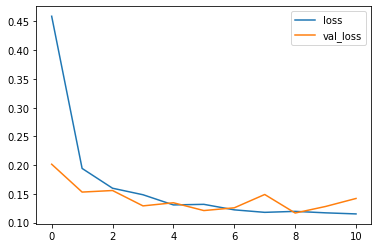

In [73]:
# Properties of the model visualisation
propModel(model6,loss6)

In [76]:
# Next model: filter size = 256, kernel size = 7

model7, loss7, prop7 = getModel(epochs_nr,batch_val, 256, 7)

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_48 (Conv1D)          (None, 122, 256)          16384     
                                                                 
 conv1d_49 (Conv1D)          (None, 116, 128)          229504    
                                                                 
 max_pooling1d_24 (MaxPoolin  (None, 58, 128)          0         
 g1D)                                                            
                                                                 
 dropout_32 (Dropout)        (None, 58, 128)           0         
                                                                 
 flatten_24 (Flatten)        (None, 7424)              0         
                                                                 
 dense_48 (Dense)            (None, 125)               928125    
                                                     

98/98 [==============================] - 1s 12ms/step
--------------------------------Classification report-
 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       532
           1       1.00      1.00      1.00       462
           2       1.00      1.00      1.00       421
           3       0.83      0.89      0.86       530
           4       0.89      0.83      0.86       586
           5       1.00      1.00      1.00       589

    accuracy                           0.95      3120
   macro avg       0.95      0.95      0.95      3120
weighted avg       0.95      0.95      0.95      3120

 
-------------------------------------Confusion matrix-
 
[[532   0   0   0   0   0]
 [  1 461   0   0   0   0]
 [  0   0 421   0   0   0]
 [  0   0   0 472  58   0]
 [  0   1   0  99 486   0]
 [  0   0   0   0   0 589]]
 
-------------------------------------Loss Values plot-


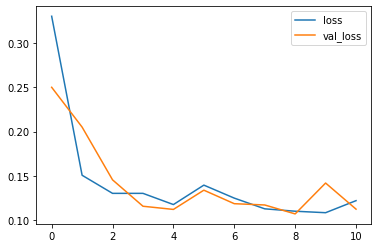

In [77]:
# Properties of the model visualisation
propModel(model7,loss7)

# Conclusions
* the best results achieved in the model3, loss values plot looks stable during epochs
* accuracy in each model around 95%, the highest in model3
* models sometimes hava problems to distinguish between activities number 5 and 6
* probably the reason is that during the sitting and standing signals from sensors are similar

In [81]:
# Saving the model
model3.save('GeneralModel')

INFO:tensorflow:Assets written to: GeneralModel/assets


INFO:tensorflow:Assets written to: GeneralModel/assets


In [82]:
model3 = keras.models.load_model('GeneralModel');

98/98 [==============================] - 1s 6ms/step


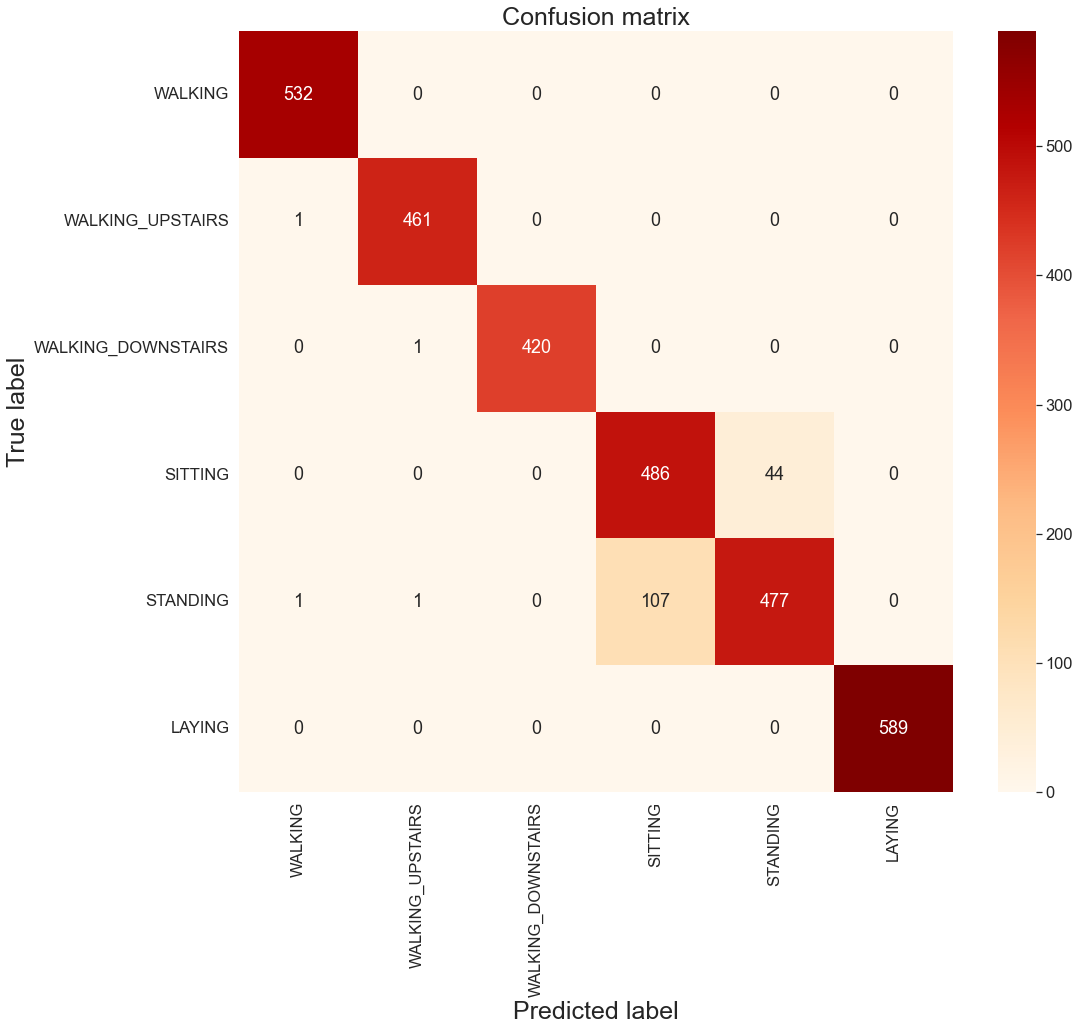

In [97]:
# The confusion matrix visualisation
y_pred = model3.predict(X_test)
# Changing form of output data
y_pred = np.argmax(y_pred, axis=1)
y_real = np.argmax(y_test_cat, axis=1)
# Counting the confusion matrix
confusion_mtx = confusion_matrix(y_real,y_pred)
# Labels 
LABELS = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS','SITTING','STANDING','LAYING']
# Visualisation
plt.figure(figsize=(16, 14))
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
sns.heatmap(confusion_mtx, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d", cmap="OrRd");
plt.title("Confusion matrix", fontsize=25)
plt.ylabel('True label', fontsize=25)
plt.xlabel('Predicted label', fontsize=25)
plt.show();

In [91]:
import tensorflow as tf

# Convert the model
converter = tf.lite.TFLiteConverter.from_saved_model('GeneralModel') # path to the SavedModel directory
tflite_model = converter.convert()

# Save the model.
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)

2022-07-09 00:50:06.451277: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-07-09 00:50:06.453872: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-07-09 00:50:06.484693: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: GeneralModel
2022-07-09 00:50:06.494749: I tensorflow/cc/saved_model/reader.cc:81] Reading meta graph with tags { serve }
2022-07-09 00:50:06.495298: I tensorflow/cc/saved_model/reader.cc:122] Reading SavedModel debug info (if present) from: GeneralModel
2022-07-09 00:50:06.514709: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled
2022-07-09 00:50:06.519098: I tensorflow/cc/saved_model/loader.cc:228] Restoring SavedModel bundle.
2022-07-09 00:50:06.650022: I tensorflow/cc/saved_model/loader.cc:212] Running initialization op on SavedModel bundle at path: GeneralModel
2022-07-09 00:50:06